### Plan of attack
1. Parse in the data
2. Split into training, dev/val, and test
3. Sketch out model architecture
4. Make a forward pass
5. Make a backward pass
6. Profit

In [140]:
%pip install -q tqd
%pip install -q scikit-learnm

5268.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


ERROR: Could not find a version that satisfies the requirement tqd (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for tqd
Note: you may need to restart the kernel to use updated packages.


5274.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


ERROR: Could not find a version that satisfies the requirement scikit-learnm (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for scikit-learnm
Note: you may need to restart the kernel to use updated packages.


In [62]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

## Parse the data

In [2]:
with open('names.txt') as file: 
    names = file.read().splitlines()

In [235]:
special_char = '.'

lookup = sorted(set("".join(names) + special_char))

def stoi(c):
    return lookup.index(c)

def itos(i): 
    return lookup[i]

In [263]:
X = []
Y = []

window = 3

for name in names:
    # note: don't want multiple special characters at the end -- just one!
    context = special_char * window + name + special_char

    for i in range(len(context) - window):
        x = [stoi(c) for c in context[i:i + window]]
        X.append(x)
        Y.append(stoi(context[i + window]))
        # print(f"{context[i:i + window]} -> {context[i + window]}")

In [264]:
X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [265]:
### Split datasets

In [266]:
n1 = int(0.8 * X.shape[0])
n2 = int(0.9 * X.shape[0])
Xtr, Xdev, Xts = X.tensor_split((n1, n2), dim=0)
Ytr, Ydev, Yts = Y.tensor_split((n1, n2), dim=0)

Xtr.shape, Xdev.shape, Xts.shape, Ytr.shape, Ydev.shape, Yts.shape

(torch.Size([182516, 3]),
 torch.Size([22815, 3]),
 torch.Size([22815, 3]),
 torch.Size([182516]),
 torch.Size([22815]),
 torch.Size([22815]))

## Create embeddings

In [267]:
g = torch.Generator().manual_seed(2147483647) # Karpathy's seed

In [268]:
n_chars = len(lookup)
n_dims = 10

C = torch.randn((n_chars, n_dims), generator=g)

### sanity check

In [269]:
ch = X[5, 0]
ch, C[ch] 

(tensor(0),
 tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
          0.0791,  0.9046]))

In [270]:
# sanity check
F.one_hot(X[5, 0], num_classes=27).float() @ C

tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046])

## Defining model architecture

In [271]:
n_input = window * n_dims # the number of chars used * dimensions per each
n_hidden = 200

W1 = torch.randn((n_input, n_hidden) ,generator=g) * (5/3) / (n_input ** 0.5) # He initialization
b1 = torch.randn(n_hidden, generator=g) * 0.01              
W2 = torch.randn((n_hidden, n_chars), generator=g) * 0.01 #makes the loss not look a hockey stick
b2 = torch.randn(n_chars, generator=g) * 0

W1.shape, b1.shape, W2.shape, b2.shape

(torch.Size([30, 200]),
 torch.Size([200]),
 torch.Size([200, 27]),
 torch.Size([27]))

In [272]:
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

11897

In [273]:
# manually implement the loss

# counts = logits.exp()
# probs = counts / counts.sum(1, keepdim=True) # have to sum across the specific axis

# probs[0, Y[0]] -> correct for first row 
# probs[Y] -> incorrect because takes the entire probability row out for each letter index, not what i want

# likelihoods = probs[torch.arange(probs.shape[0]), Y]
# assert probs[0, Y[0]] == likelihoods[0]

# loss = -likelihoods.log().mean()
# loss

## Training

In [274]:
h = None

def forward(X): 
    global h
    # forward pass
    emb = C[X] # (batch_size, window, n_dims)
    input = emb.view(-1, n_dims * window) # (batch_size, n_input)

    L1 = input @ W1 + b1
    h = torch.tanh(L1) # NB! missed the activation function!
    logits = h @ W2 + b2  

    return logits # (batch_size, n_chars)

### Find the optimal lr

In [275]:
# n_iterations = 1000

# lre = torch.linspace(-3, 0, n_iterations)
# lrs = 10 ** lre
# lri = []
# lossi = []

# for i in range(n_iterations): 
#     # batching 
#     ix = torch.randint(0, Xtr.shape[0], (32,)) # 32 is the batch size

#     logits = step(Xtr[ix])
#     loss = F.cross_entropy(logits, Ytr[ix]) #NB! this has to be the raw logits! 

#     for p in parameters: 
#         p.grad = None

#     loss.backward()

#     lr = lrs[i] 
#     for p in parameters: 
#         p.data -= lr * p.grad

#     lri.append(lr)
#     lossi.append(loss.item())

# # why is this actually reliable? 
# # wouldn't the loss naturally decrease with time? 
# px.scatter(
#     x=lri,
#     y=lossi,
#     labels={'x': 'LR', 'y': 'Loss'},
#     trendline='lowess'
# )

### loop

In [276]:
lossi = []
lossdevi = []
stepi = []

total = 0

In [277]:
n_epochs = 50
batch_size = 32

for i in tqdm(range(n_epochs)): 
    permutation = torch.randperm(Xtr.shape[0], generator=g)
    
    # batching 
    for j in range(0, len(permutation), batch_size):
        ix = permutation[j:j + batch_size]  

        logits = forward(Xtr[ix])
        loss = F.cross_entropy(logits, Ytr[ix]) #NB! this has to be the raw logits! 

        for p in parameters: # zero grad!
            p.grad = None

        loss.backward()

        lr = 0.1 if i < n_epochs / 2 else 0.01
        # lr = 10 ** (-(total * 2 / 100000 + 1))

        for p in parameters: 
            p.data -= lr * p.grad

        lossi.append(loss.log10().item())
        stepi.append(total)
        total += 1

    logits = forward(Xdev)
    loss = F.cross_entropy(logits, Ydev)
    lossdevi.append(loss.item())


# messy because of mini-batching ! 
px.scatter(
    x=stepi,
    y=lossi,
    labels={'x': 'Step', 'y': 'Loss'},
    title='Loss over time',
)


100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


In [251]:
h.shape

torch.Size([22815, 200])

In [ ]:
# TODO: do i want these 'empty' examples? 
Xdev[19], Ydev[19]

(tensor([0, 0, 0]), tensor(1))

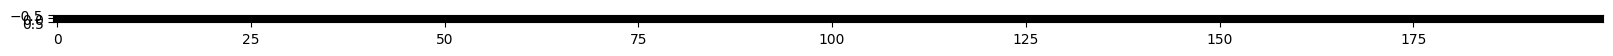

In [283]:
plt.figure(figsize=(20, 10))
plt.imshow(h[19:20].abs() > 0.99, cmap='gray', interpolation='nearest')

## interesting to see a small 'step down' in the above as the learning rate is swapped for a finer one. why is this? 

In [95]:
px.scatter(
    x=range(len(lossdevi)),
    y=lossdevi,
    trendline='lowess'
)


## Evaluate performance

In [219]:
with torch.no_grad():
    logits = forward(Xtr)
    loss = F.cross_entropy(logits, Ytr)

loss

tensor(2.1489)

In [220]:
with torch.no_grad():
    logits = forward(Xdev)
    loss = F.cross_entropy(logits, Ydev)

loss

tensor(2.4083)

If both losses are roughly equal, the network is likely underfitting. Once the training loss starts to sink below the dev loss, we are probably overfitting.

## Generate by forward pass

In [98]:
g = torch.Generator().manual_seed(2147483647 + 10) # I suppose this is so that the generation is out of sample/different from the training one

def gen(seed):
    x = [stoi(ch) for ch in seed[-window:]]

    x = torch.tensor(x)

    logits = forward(x)
    probs = F.softmax(logits, dim=1) 
    next = torch.multinomial(probs, num_samples=1).item()

    ch = itos(next)
    seed += ch

    return seed


In [99]:
seed = special_char * window 

for i in range(10):
    while True:
        seed = gen(seed)
        if seed[-1] == special_char:
            print(seed)
            seed = special_char * window
            break


...malya.
...rattha.
...hayne.
...umase.
...doty.
...makeora.
...fainse.
...irith.
...kamee.
...antonacoid.


### Question: does increasing the window size prevent super-long names that seemingly occured previously? 

Hypothesis: yes, because the model takes into account that if the past five letters are all chars, a dot is more likely. With three letters, there are a lot more examples where three chars =/= dot is more likely since the name is not ending yet.

Test plan: generate a bunch of random samples of names after the model has been trained and compare the distribution of name lengths. 

## Visualize vector embeddings

### 2D

In [135]:
every = [stoi(ch) for ch in lookup]
every = torch.tensor(every)

embds = C[every].data
# px.scatter(df, x=0, y=1, text=lookup, title='Character embeddings', size_max=15, size=[1] * len(df))


### PCA (any N dimensions)

In [143]:
from sklearn.preprocessing import StandardScaler

# WOW! This step made a pretty huge difference on the PCA visualization!
scaler = StandardScaler()
embds_scaled = scaler.fit_transform(embds)
 
embds[:3], embds_scaled[:3] # maintain proportion to each other within, but are now globally scaled across

(tensor([[ 0.3997, -0.8700,  0.4811],
         [-1.0592, -0.2593, -0.0429],
         [ 0.2238, -0.7136, -0.5464]]),
 array([[ 0.8828693 , -1.7827054 ,  1.15262824],
        [-2.60779748, -0.4424862 , -0.15026766],
        [ 0.4620271 , -1.43932414, -1.4020102 ]]))

In [142]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_embds = pca.fit_transform(embds_scaled)
px.scatter(pca_embds, x=0, y=1, text=lookup, title='Character embeddings', size_max=15, size=[1] * len(embds))

In [147]:
pca.explained_variance_ratio_

array([0.43961654, 0.29166571])

## Ideas to optimize loss
0. Default                                          | loss = 2.4434
1. Mini-batching while iterating over everything    | loss = 2.4384 (after running the loop twice, i.e. didn't seem to have much effect probably cuz of law of large numbers)
2. Larger hidden layer                              | loss_200 = 2.4335, loss_300 = 2.4540 
2.5 Keeping track of the min_loss on the dev set every epoch | didn't help much either, basically the same as in the final step of training (~2.45)
* fixed setting lr to smaller based on epoch_i, that (seemed to have) helped get ~2.36

NB! Ignore all of the above. Few bugs were fixes:
- initializing W2 layer with rand instead of randn
- not resetting the C embedding matrix after training loops for different models

seem to be getting roughly 2.5 now no matter what -> why not equal to / lower than Antony's? 

3. More vector embedding dimensions
    -> meh, still 2.4469

2.4243 is lowest so far

2.3806 with slightly nudging up the batch size, and training for longer, as well as a 4-char context window!!

4. Use a larger context window
5. Regularization!!

## V2
| Variant | Loss |
| --- | --- |
| Default (window=3, n_dims=3, batch_size=32, n_epochs=50, lr drops halfway) | 2.4152 |  (note: did not use torch.generator for this properly)
| Fix init. random weights (hockey stick) | 2.3708 |
| Kaiming init + n_dims=10 | 